In [1]:
import sys
import os
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json
os.system("")

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))

Welcome to JupyROOT 6.18/00


In [2]:
def in_ipynb():
    try:
        cfg = get_ipython().config 
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False
    
def plot_mva(df, column, bins, logscale=False, ax=None, title=None, ls='dashed', alpha=0.5, sample='',cat="Matchlabel",Wt="Wt"):
    histtype="bar" 
    if sample is 'test':
        histtype="step"      
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby(cat):
        if name == 0:
            label="background"
        else:
            label="signal"
        group[column].hist(bins=bins, histtype=histtype, alpha=1,
                           label=label+' '+sample, ax=ax, density=True, ls=ls, weights =group[Wt],linewidth=2)
    #ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend(fontsize=10)
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

In [3]:
def plot_roc_curve(df, score_column, tpr_threshold=0, ax=None, color=None, linestyle='-', label=None,cat="Matchlabel",Wt="Wt"):
    from sklearn import metrics
    if ax is None: ax = plt.gca()
    if label is None: label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df[cat], df[score_column],sample_weight=df[Wt])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    auc=metrics.auc(fpr, tpr)
    label=label+' auc='+str(round(auc*100,1))+'%'
    ax.plot(tpr, fpr, label=label, color=color, linestyle=linestyle,linewidth=2,alpha=0.7)
    ax.legend()
    return auc

def plot_single_roc_point(df, var='Fall17isoV1wpLoose', 
                          ax=None , marker='o', 
                          markersize=6, color="red", label='', cat="Matchlabel",Wt="Wt"):
    backgroundpass=df.loc[(df[var] == 1) & (df[cat] == 0),Wt].sum()
    backgroundrej=df.loc[(df[var] == 0) & (df[cat] == 0),Wt].sum()
    signalpass=df.loc[(df[var] == 1) & (df[cat] == 1),Wt].sum()
    signalrej=df.loc[(df[var] == 0) & (df[cat] == 1),Wt].sum()
    backgroundrej=backgroundrej/(backgroundpass+backgroundrej)
    signaleff=signalpass/(signalpass+signalrej)
    ax.plot([signaleff], [1-backgroundrej], marker=marker, color=color, markersize=markersize, label=label)
    ax.legend()

In [4]:
if in_ipynb(): 
    print("In IPython")
    exec("import Tools.TrainConfig as Conf")
    TrainConfig="Tools/TrainConfig"
else:
    TrainConfig=sys.argv[1]
    prGreen("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

W0318 20:30:02.837873 140619606701888 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'IPKernelApp': {'connection_file': '/scratch/akapoor/.local/share/jupyter/runtime/kernel-c38d564e-c233-4464-a816-1522be8af85d.json'}, 'InteractiveShellApp': {'extensions': <traitlets.config.loader.LazyConfigValue object at 0x7fe47ae366d8>}}
In IPython


In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

 Running in debug mode : Only every 10th event will be used


In [6]:

prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/")

 Making output directory


0

In [7]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [8]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(Conf.SigFiles,Conf.SigXsecWts,Conf.SigCuts):
    if Conf.Debug==True:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(Conf.BkgFiles,Conf.BkgXsecWts,Conf.BkgCuts):
    if Conf.Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)

 Making data frames


In [9]:
Sigdf[cat]=1
Bkgdf[cat]=0

Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

#Reweighing
Sigdf[weight]=1
Bkgdf[weight]=1

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

df_final["NewWt"]=1

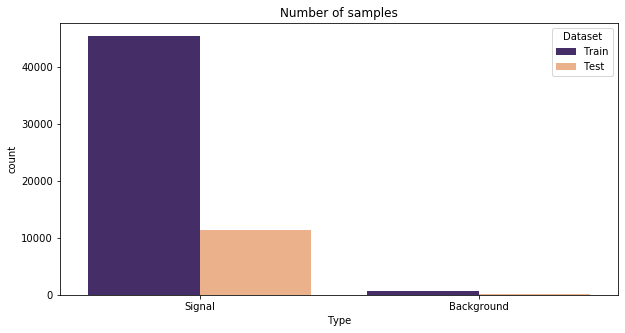

In [10]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")
    

In [11]:
def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",MVA="XGB_1"):
    fig, axes = plt.subplots(1, len(features), figsize=(len(Conf.features)*5, 5))
    prGreen("Making"+Set+" dataset feature plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            group_df[features[m-1]].hist(histtype='step', bins=feature_bins[m-1], alpha=0.7,label=label[i], ax=axes[m-1], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=4)
            #df_new = pd.concat([group_df, df_new],ignore_index=True, sort=False)                                                                                            
        axes[m-1].legend(loc='upper right')
        axes[m-1].set_xlabel(features[m-1])
        axes[m-1].set_yscale("log")
        axes[m-1].set_title(features[m-1]+" ("+Set+" Dataset)")
    plt.savefig(Conf.OutputDirName+"/"+MVA+"_"+"featureplots_"+Set+".png")

In [12]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]

    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    Wt_train = np.asarray(Wt_train)
    
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)
    Wt_test = np.asarray(Wt_test)
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 XGB_1 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.0s finished


 Expected accuracy of XGB model = 98.7%
 XGB Best Parameters
 {'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB
 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 XGB_2 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   14.9s finished


 Expected accuracy of XGB model = 98.6%
 XGB Best Parameters
 {'gamma': 0.5, 'learning_rate': 0.01}
 Plotting output response for XGB
 Plotting ROC for XGB


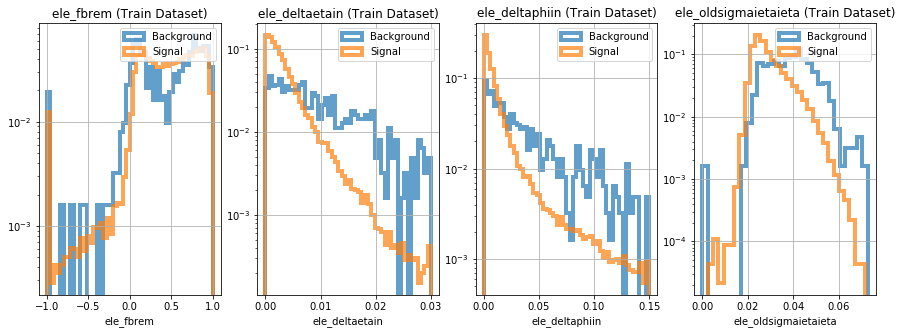

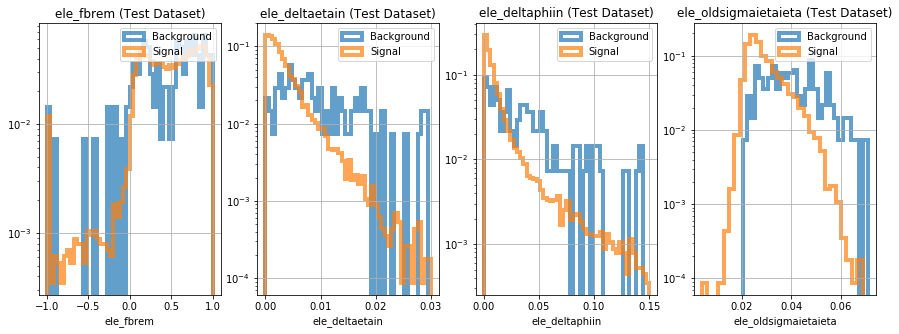

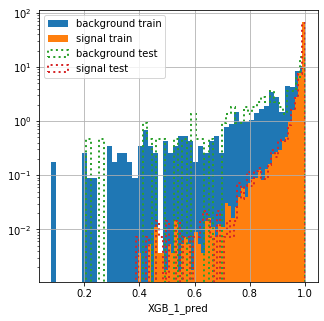

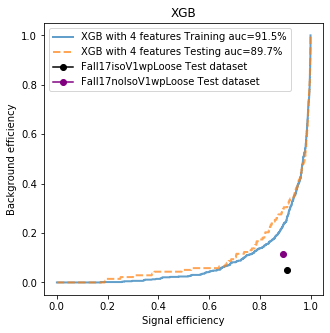

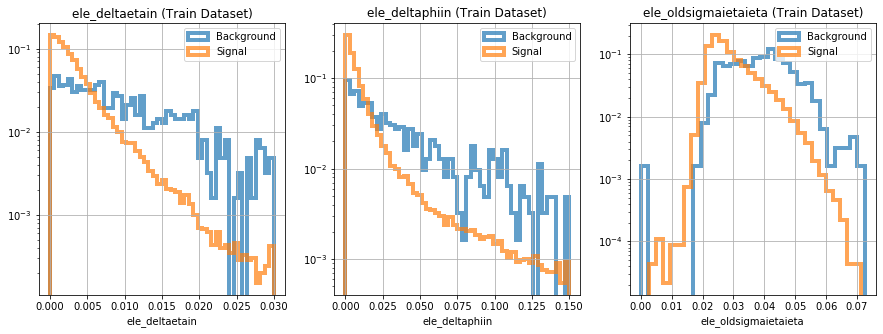

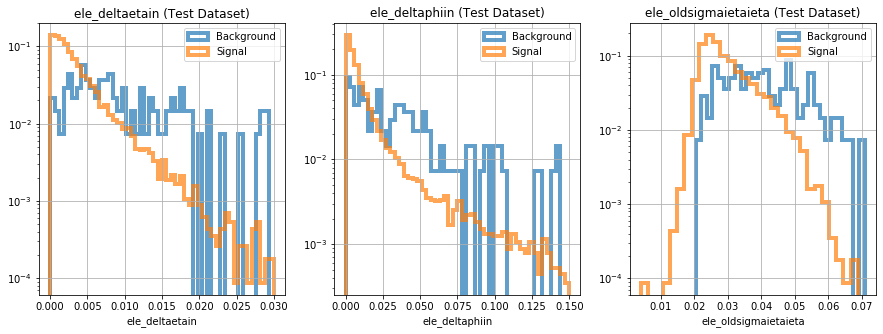

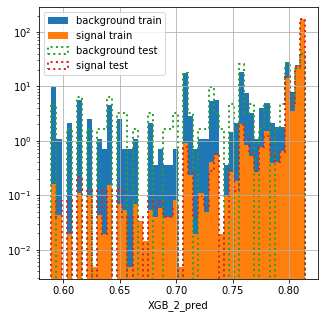

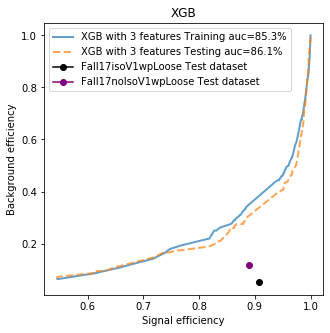

In [13]:
for MVA in Conf.MVAs:
    
    if 'XGB' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],scoring = 'accuracy',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)

        prGreen("Expected accuracy of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
    
        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=True)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=True)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("XGB")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"_"+"XGBROC.png")

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 DNN fitting running
Train on 46130 samples, validate on 11533 samples
Epoch 1/100
46130/46130 [==============================] - 1s 23us/sample - loss: 0.0814 - acc: 0.9865 - val_loss: 0.0641 - val_acc: 0.9880
Epoch 2/100
46130/46130 [==============================] - 1s 17us/sample - loss: 0.0797 - acc: 0.9865 - val_loss: 0.0634 - val_acc: 0.9880
Epoch 3/100
46130/46130 [==============================] - 1s 16us/sample - loss: 0.0773 - acc: 0.9865 - val_loss: 0.0628 - val_acc: 0.9880
Epoch 4/100
46130/46130 [==============================] - 1s 17us/sample - loss: 0.0757 - acc: 0.9865 - val_loss: 0.0617 - val_acc: 0.9880
Epoch 5/100
46130/46130 [==============================] - 1s 17us/sample - loss: 0.0732 - acc: 0.9865 - val_loss: 0.0609 - val_acc: 0.9880
Epoch 6/100
46130/46130 [==============================] - 1s 18us/sample - loss: 0.0728 - acc: 0.9865 - val_loss: 0.0600 - val_acc: 0.9880
Epoch 7/100
46130/46

Epoch 58/100
46130/46130 [==============================] - 1s 18us/sample - loss: 0.0585 - acc: 0.9865 - val_loss: 0.0498 - val_acc: 0.9880
Epoch 59/100
46130/46130 [==============================] - 1s 17us/sample - loss: 0.0584 - acc: 0.9865 - val_loss: 0.0497 - val_acc: 0.9880
Epoch 60/100
46130/46130 [==============================] - 1s 16us/sample - loss: 0.0587 - acc: 0.9865 - val_loss: 0.0498 - val_acc: 0.9880
Epoch 61/100
46130/46130 [==============================] - 1s 18us/sample - loss: 0.0582 - acc: 0.9865 - val_loss: 0.0497 - val_acc: 0.9880
Epoch 62/100
46130/46130 [==============================] - 1s 17us/sample - loss: 0.0586 - acc: 0.9865 - val_loss: 0.0500 - val_acc: 0.9880
Epoch 63/100
46130/46130 [==============================] - 1s 18us/sample - loss: 0.0583 - acc: 0.9865 - val_loss: 0.0493 - val_acc: 0.9880
Epoch 64/100
46130/46130 [==============================] - 1s 18us/sample - loss: 0.0588 - acc: 0.9865 - val_loss: 0.0495 - val_acc: 0.9880
Epoch 65/100


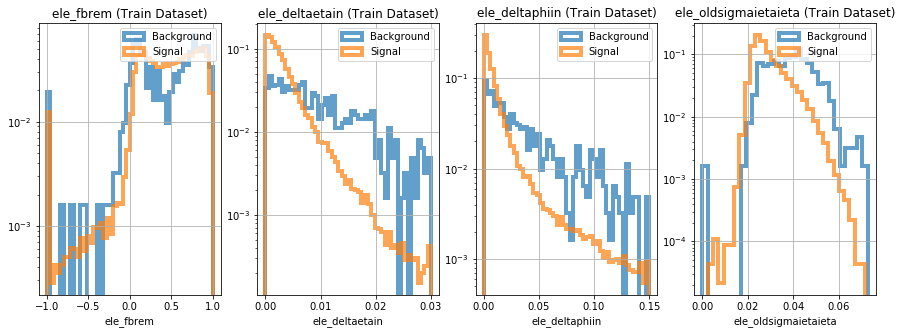

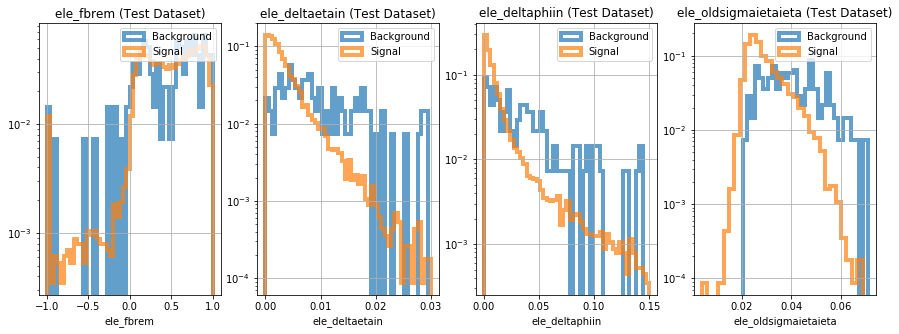

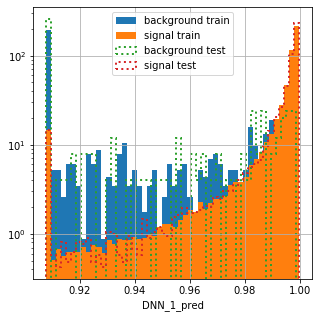

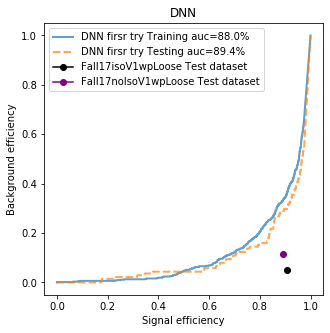

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
for MVA in Conf.MVAs:
    if 'DNN' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen("DNN fitting running")
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        modelDNN=Conf.DNNDict[MVA]['model']
        modelDNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=Conf.DNNDict[MVA]['lr']), metrics=['accuracy',])
        train_history = modelDNN.fit(X_train,Y_train,epochs=Conf.DNNDict[MVA]['epochs'],batch_size=Conf.DNNDict[MVA]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/modelDNN.h5")
        df_final.loc[TrainIndices,MVA+"_pred"]=modelDNN.predict(X_train)
        df_final.loc[TestIndices,MVA+"_pred"]=modelDNN.predict(X_test)
    
        prGreen("Plotting output response for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=True)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=True)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"_"+"DNNMVA.png")
    
        prGreen("Plotting ROC for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("DNN")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"_"+"DNNROC.png")

In [19]:
if 'Genetic' in Conf.MVAs:
    prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

 Plotting Final ROC


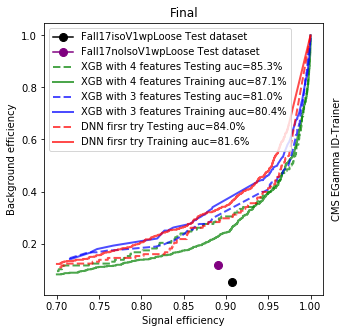

In [20]:
##PlotFinalROC
prGreen("Plotting Final ROC")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if len(Conf.OverlayWP)>0:
    for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
        plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
if len(Conf.MVAs)>0:
    for color,MVAi in zip(Conf.MVAColors,Conf.MVAs):
        plot_roc_curve(df_final.query('TrainDataset==0'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='--', label=Conf.MVALabels[MVAi]+' Testing',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==1'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='-', label=Conf.MVALabels[MVAi]+' Training',cat=cat,Wt=weight)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("Final")
    axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=axes.transAxes)
plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [21]:
os.system("convert "+Conf.OutputDirName+"/TotalStat_TrainANDTest.png "+Conf.OutputDirName+"/*ROC*png "+Conf.OutputDirName+"/mydoc.pdf")
prGreen("Done!! Please find the quick look pdf here "+Conf.OutputDirName+"/mydoc.pdf")

 Done!! Please find the quick look pdf here Output/mydoc.pdf


convert: /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/libtiff.so.5: no version information available (required by /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/libMagickCore-7.Q16HDRI.so.6)
convert: UnableToOpenConfigureFile `magic.xml' @ warning/configure.c/GetConfigureOptions/714.
convert: UnableToOpenBlob 'Output/TotalStat_TrainANDTest.png': No such file or directory @ error/blob.c/OpenBlob/3468.
convert: UnableToOpenBlob 'Output/*ROC*png': No such file or directory @ error/blob.c/OpenBlob/3468.
convert: UnableToOpenConfigureFile `delegates.xml' @ warning/configure.c/GetConfigureOptions/714.
convert: UnableToOpenBlob 'Output/*ROC*png': No such file or directory @ error/blob.c/OpenBlob/3468.
convert: NoDecodeDelegateForThisImageFormat `' @ error/constitute.c/ReadImage/512.
convert: NoImagesDefined `Output/mydoc.pdf' @ error/convert.c/ConvertImageCommand/3275.
